<a href="https://colab.research.google.com/github/meetu30/ISS/blob/main/cosine_using_word2vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
'''
Cosine similarity on word2Vec embedding
Steps -
1. tokenize the sentences in each row of the "Case"
2. create a new column called "CaseCleaned_tokens"
3. implement word embedding method (word2vec) as features
4. append the vectors of each row to a new column called "case_embedding"
5. calculate the cosine similary between the query vector and each row of the entire abstract embedding column
6. append the similarity scores to a new column called "cosine_score"
7. sort the column and rank the top n cases with highest cosine score

**Reference - https://www.kaggle.com/yufenhou/recommender-system-eda-word2vec-cosine-similarity
'''


'\nCosine similarity on word2Vec embedding\nSteps -\n1. tokenize the sentences in each row of the "Case"\n2. create a new column called "CaseCleaned_tokens"\n3. implement word embedding method (word2vec) as features\n4. append the vectors of each row to a new column called "case_embedding"\n5. calculate the cosine similary between the query vector and each row of the entire abstract embedding column\n6. append the similarity scores to a new column called "cosine_score"\n7. sort the column and rank the top n cases with highest cosine score\n\n'

In [5]:
# download required libraries
import numpy as np 
import pandas as pd
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns

#nltk.download("stopwords")
#nltk.download('wordnet')
#nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from nltk.stem import PorterStemmer
from nltk.tokenize import RegexpTokenizer
from gensim.models import word2vec
from sklearn import metrics
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
import json
import os

import warnings
warnings.filterwarnings("ignore")

In [2]:
#mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
#Read the csv
fileName = "/content/drive/My Drive/ISS/CompiledCases.csv"

column = "Case"
Data = pd.read_csv(fileName,encoding="Latin-1")
Data = Data.replace(np.nan,' ',regex=True)
sentences = list(Data[column])
Data.head()

,ID,Case
0,1,On behalf of Ms. Amira I would like to ask for...
1,2,The following information has been supplied by...
2,3,I hope you all are well and sane in these chal...
3,4,"The child protection office in Beirut, Lebanon..."
4,5,I am writing from Children and Families Across...


In [7]:
###################################  Data Cleaning #######################################

In [8]:
import nltk
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [54]:
stop = nltk.corpus.stopwords.words('english')
#stop = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [55]:

def data_preprocessing(text):
    
    text = ' '.join(re.sub('https?://\S+|www\.\S+','',text).split())
    text = text.replace('\n', '')
    text = re.sub("[!@#$+%*:()/<.=,—']", '', text)
    text = ' '.join([word for word in text.split() if word not in stop])
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split()])

    return text



In [10]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [44]:
ps = nltk.PorterStemmer()

import re
import string
print(string.punctuation)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [56]:
Data['CaseCleaned'] = Data['Case'].apply(lambda x: data_preprocessing(x.lower()))

In [57]:
# to display more of the text content
pd.set_option('display.max_colwidth', 200)
Data.head(5)

,ID,Case,CaseCleaned,CaseCleaned_tokens,case_embedding,cos_sim
0,1,"On behalf of Ms. Amira I would like to ask for your cooperation in tracing her biological mother and perhaps other family members. The biological mother possibly moved to Canada, according to info...",behalf m amira would like ask cooperation tracing biological mother perhaps family member biological mother possibly moved canada according information unhcr received however cannot sure lot infor...,"[behalf, m, amira, would, like, ask, cooperation, tracing, biological, mother, perhaps, family, member, biological, mother, possibly, moved, canada, according, information, unhcr, received, howeve...","[-0.13701937504405523, 0.07367983590564549, 0.1038906877161935, 0.1360813578181533, 0.2598285998429426, 0.05355278468579689, 0.12022619213288029, 0.26533594617239115, 0.1447776429228146, -0.148707...",0.999580
1,2,The following information has been supplied by the Youth Welfare Office in Berlin The Social Worker who made the child welfare alert has been responsible for the family since 2014. The father of L...,following information supplied youth welfare office berlin social worker made child welfare alert responsible family since 2014 father lara fadi come lebanon deported back country 2017 massively c...,"[following, information, supplied, youth, welfare, office, berlin, social, worker, made, child, welfare, alert, responsible, family, since, 2014, father, lara, fadi, come, lebanon, deported, back,...","[-0.13544285625299152, 0.07190681342347484, 0.10186222077854969, 0.13541323313529136, 0.25843511236753375, 0.05288814909451156, 0.11822482587229977, 0.26319026747967805, 0.14420434085806608, -0.14...",0.999582
2,3,"I hope you all are well and sane in these challenging times. I kindly ask you for your support in the case of Anas, d.o.b. 30.06.2004. Unfortunately I have only few information about the case: The...",hope well sane challenging time kindly ask support case ana dob 30062004 unfortunately information case mother nadia anaslive syria contact â¦ mobile â¦ father â¦ life still hamburg family live...,"[hope, well, sane, challenging, time, kindly, ask, support, case, ana, dob, 30062004, unfortunately, information, case, mother, nadia, anaslive, syria, contact, â¦, mobile, â¦, father, â¦, life...","[-0.1296953699065358, 0.06963082278465486, 0.09771905269157777, 0.12972108350337255, 0.24714935029689394, 0.050264055749231366, 0.11364461276268786, 0.25185828834324064, 0.13829091219301665, -0.14...",0.999583
3,4,"The child protection office in Beirut, Lebanon, requests ISS assistance regarding a 6-year-old Syrian child, currently living in Germany, in order to facilitate the re-establishment of contact bet...",child protection office beirut lebanon request i assistance regarding 6-year-old syrian child currently living germany order facilitate re-establishment contact father lebanon ensure possible reun...,"[child, protection, office, beirut, lebanon, request, i, assistance, regarding, 6-year-old, syrian, child, currently, living, germany, order, facilitate, re-establishment, contact, father, lebanon...","[-0.13612721323395965, 0.07229185969921492, 0.10164022053352162, 0.1357827280386181, 0.2602178257011022, 0.053437045865164054, 0.11929518883092814, 0.263619515869855, 0.14535026888436733, -0.14819...",0.999571
4,5,"I am writing from Children and Families Across Borders, UK, to request your assistance on this case. It involves two children who are placed with foster carers in the UK. The foster carers travel ...",writing child family across border uk request assistance case involves two child placed foster carers uk foster carers travel lebanon frequently would like take child holiday child foster care chi...,"[writing, child, family, across, border, uk, request, assistance, case, involves, two, child, placed, foster, carers, uk, foster, carers, travel, lebanon, frequently, would, like, take, child, hol...","[-0.1311932939734817, 0.06961763136322348, 0.099100409

Text(0.5, 1.0, 'Prominent words in Case Corpus Word Cloud')

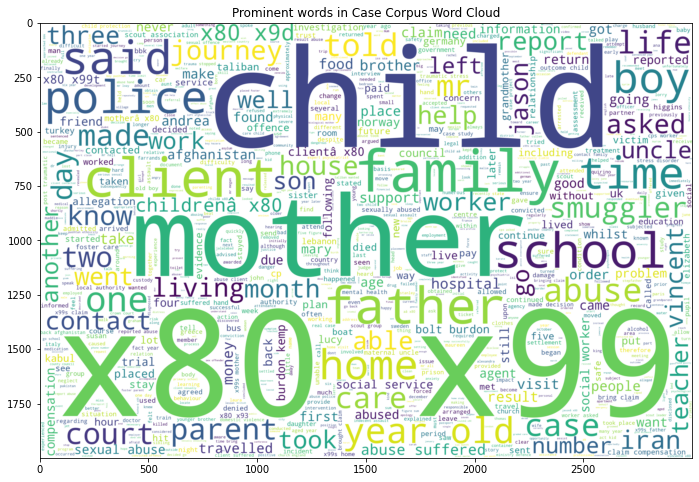

In [58]:
contentCorpus = Data.CaseCleaned.values
plt.figure(figsize = (12, 8))
wordcloud = WordCloud(width = 3000,height = 2000,background_color="white",max_words=1000).generate(str(contentCorpus))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Prominent words in Case Corpus Word Cloud')

In [59]:
tokenized_sentences_clean = [sentence.split() for sentence in Data['CaseCleaned'].values]

In [60]:
Data['CaseCleaned_tokens'] = tokenized_sentences_clean

In [61]:
Data.head(5)

,ID,Case,CaseCleaned,CaseCleaned_tokens,case_embedding,cos_sim
0,1,"On behalf of Ms. Amira I would like to ask for your cooperation in tracing her biological mother and perhaps other family members. The biological mother possibly moved to Canada, according to info...",behalf m amira would like ask cooperation tracing biological mother perhaps family member biological mother possibly moved canada according information unhcr received however cannot sure lot infor...,"[behalf, m, amira, would, like, ask, cooperation, tracing, biological, mother, perhaps, family, member, biological, mother, possibly, moved, canada, according, information, unhcr, received, howeve...","[-0.13701937504405523, 0.07367983590564549, 0.1038906877161935, 0.1360813578181533, 0.2598285998429426, 0.05355278468579689, 0.12022619213288029, 0.26533594617239115, 0.1447776429228146, -0.148707...",0.999580
1,2,The following information has been supplied by the Youth Welfare Office in Berlin The Social Worker who made the child welfare alert has been responsible for the family since 2014. The father of L...,following information supplied youth welfare office berlin social worker made child welfare alert responsible family since 2014 father lara fadi come lebanon deported back country 2017 massively c...,"[following, information, supplied, youth, welfare, office, berlin, social, worker, made, child, welfare, alert, responsible, family, since, 2014, father, lara, fadi, come, lebanon, deported, back,...","[-0.13544285625299152, 0.07190681342347484, 0.10186222077854969, 0.13541323313529136, 0.25843511236753375, 0.05288814909451156, 0.11822482587229977, 0.26319026747967805, 0.14420434085806608, -0.14...",0.999582
2,3,"I hope you all are well and sane in these challenging times. I kindly ask you for your support in the case of Anas, d.o.b. 30.06.2004. Unfortunately I have only few information about the case: The...",hope well sane challenging time kindly ask support case ana dob 30062004 unfortunately information case mother nadia anaslive syria contact â¦ mobile â¦ father â¦ life still hamburg family live...,"[hope, well, sane, challenging, time, kindly, ask, support, case, ana, dob, 30062004, unfortunately, information, case, mother, nadia, anaslive, syria, contact, â¦, mobile, â¦, father, â¦, life...","[-0.1296953699065358, 0.06963082278465486, 0.09771905269157777, 0.12972108350337255, 0.24714935029689394, 0.050264055749231366, 0.11364461276268786, 0.25185828834324064, 0.13829091219301665, -0.14...",0.999583
3,4,"The child protection office in Beirut, Lebanon, requests ISS assistance regarding a 6-year-old Syrian child, currently living in Germany, in order to facilitate the re-establishment of contact bet...",child protection office beirut lebanon request i assistance regarding 6-year-old syrian child currently living germany order facilitate re-establishment contact father lebanon ensure possible reun...,"[child, protection, office, beirut, lebanon, request, i, assistance, regarding, 6-year-old, syrian, child, currently, living, germany, order, facilitate, re-establishment, contact, father, lebanon...","[-0.13612721323395965, 0.07229185969921492, 0.10164022053352162, 0.1357827280386181, 0.2602178257011022, 0.053437045865164054, 0.11929518883092814, 0.263619515869855, 0.14535026888436733, -0.14819...",0.999571
4,5,"I am writing from Children and Families Across Borders, UK, to request your assistance on this case. It involves two children who are placed with foster carers in the UK. The foster carers travel ...",writing child family across border uk request assistance case involves two child placed foster carers uk foster carers travel lebanon frequently would like take child holiday child foster care chi...,"[writing, child, family, across, border, uk, request, assistance, case, involves, two, child, placed, foster, carers, uk, foster, carers, travel, lebanon, frequently, would, like, take, child, hol...","[-0.1311932939734817, 0.06961763136322348, 0.099100409

In [63]:
model = word2vec.Word2Vec(tokenized_sentences_clean, size = 100, min_count=1)

In [64]:
def buildWordVector(word_list, size):
    #function to average all words vectors in a given paragraph
    vec = np.zeros(size)
    count = 0.
    for word in word_list:
        if word in model.wv:
            vec += model.wv[word]
            count += 1.
    if count != 0:
        vec /= count
    return vec

In [65]:
Data['case_embedding'] = Data['CaseCleaned_tokens'].apply(lambda x: buildWordVector(x, size = 100))

In [66]:
Data.shape

(216, 6)

In [25]:
def embedding_query(query):
    query = query.split(' ')
    query_vec = np.zeros(100).reshape((1,100))
    count = 0
    for word in query:
        if word in model.wv:
            query_vec += model.wv[word]
            count += 1.
    if count != 0:
        query_vec /= count
    return query_vec

In [67]:
def get_similarity(query,n_top):
    query_vec = embedding_query(query)
    Data["cos_sim"] = Data['case_embedding'].apply(
        lambda x: metrics.pairwise.cosine_similarity(
            [x],query_vec.reshape(1,-1))[0][0])
    top_list = (Data.sort_values("cos_sim", ascending=False)
                [["ID","Case","cos_sim"]]
                .drop_duplicates()[:n_top])
    return top_list

In [68]:
get_similarity('2',10)

,ID,Case,cos_sim
80,81,"Allegation: The boyâs mother, Susan, alleged that Mary S., the boyâs maternal\ngrandmother and legal guardian, is physically abusive and intimidating to 15yr old\nJason. Yesterday 9-28-07, she...",0.999505
7,8,Karim (6) and Ziad (8) are the sons of two divorced Lebanese nationals. The father remarried a Lebanese woman who also had a Canadian passport and the four of them went to live in Canada. Followin...,0.999504
68,69,"The mother was stressed by family duties and was helpless with the baby. When she was left alone with the baby, she hit the babyâs head against a doorframe, dropped her and pressed the head with...",0.999504
55,56,"Maria and her brother, Francisco, lived in New Jersey with their drug-dependent mother. After deeming her mother unfit to care for her children, a child services agency in New Jersey took them int...",0.999503
62,63,John and Jessie are brothers who were living in Costa Rica. They were taken into custody by Costa Rican social services after they reported to their teachers they were suffering abuse at home. Soc...,0.999503
210,211,Sifiso I am Sifiso. I am 11 years old. I have always loved playing soccer. I wanted to play professional soccer for Amakhosi. My parents saved money and sacrificed many things to send me to Jozi t...,0.999501
106,107,"Miss E sustained catastrophic brain injury when she was two months old, as a result of a violent shaking by her father who subsequently pleaded guilty to the offence of assault causing grievous bo...",0.999500
48,49,"Amara, a citizen of India, was abandoned by her family when she was only 16-years- old. She had experienced physical abuse and an attempt had been made to force her into marriage with a relative. ...",0.999500
69,70,The father abused alcohol and drugs. Previous hospitalization due to falling from the parentâs lap. Battering occurred in unclear circumstances when the mother was absent.,0.999500
77,78,"Older sibling taken into custodial care because of battering Motherâs psychotherapy ceased and after that the battering started. The Mother let no One taken care of the child, not even the fathe...",0.999499
